# Gemini API Python - Time Series Analysis

*   Domain: Time Series Analysis
*   Problem: Fall Detection using Wrist Accelerometer Data
*   Dataset: SmartFall2018 | [Download Dataset](https://userweb.cs.txstate.edu/~hn12/data/SmartFallDataSet/SmartFall/) | [Read Paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC6210545/)

## Install the SDK

The Python SDK for the Gemini API is contained in the [`google-generativeai`](https://pypi.org/project/google-generativeai/) package. Install the dependency using pip:

In [1]:
!pip install -q -U google-generativeai

## Set up your API key

To use the Gemini API, you'll need an API key. If you don't already have one, create a key in Google AI Studio.

<a class="button" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GOOGLE_API_KEY`. Then pass the key to the SDK:

In [2]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize and Test the Generative Model

Before you can make any API calls, you need to initialize the Generative Model.

In [3]:
model = genai.GenerativeModel('gemini-1.5-pro')

## Test the Model by Generating Text

In [4]:
response = model.generate_content("Write a story about a magic backpack using 50 words only.")
print(response.text)

Lily's backpack hummed.  Reaching in, she pulled out a shimmering seashell, then a telescope, then a warm croissant.  It always held exactly what she needed, a comforting weight against her back, a whispered promise of adventure.



# Load dataset

In [5]:
import os
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir('/content/drive/MyDrive/TXState/Reserach/SmartFall-2018')

os.getcwd()

'/content/drive/MyDrive/TXState/Reserach/SmartFall-2018'

In [91]:
import pandas as pd

# Load the provided training and testing datasets
training_data_path = 'SmartFall Training.csv'

# Read the CSV files
training_data = pd.read_csv(training_data_path)

# Clean column names by stripping leading/trailing spaces
training_data.columns = training_data.columns.str.strip()

# Display the first few rows of each dataset to understand their structure
training_data_head = training_data.head()

training_data_head

,ms_accelerometer_x,ms_accelerometer_y,ms_accelerometer_z,outcome
0,1.058105,0.096436,0.113037,0
1,0.718506,0.233887,0.220703,0
2,0.718506,0.233887,0.220703,0
3,0.960205,0.190430,0.051270,0
4,0.960205,0.190430,0.051270,0


## Create Overlapping Windows

In [8]:
import numpy as np

# Function to create sliding windows with a specified stride
def sliding_windows(data, labels, window_size, stride=25, threshold=0.5):
    samples = []
    sample_labels = []
    num_samples = len(data) - window_size + 1

    for start in range(0, num_samples, stride):
        window = data[start:start + window_size]
        window_labels = labels[start:start + window_size]

        # Check how many falls are in the window
        num_falls = np.sum(window_labels)

        # Label the window based on threshold
        if num_falls / window_size >= threshold:
            window_label = 1
        else:
            window_label = 0

        # Append window and its label
        samples.append(window)
        sample_labels.append(window_label)

    return np.array(samples), np.array(sample_labels)

# Prepare the data in 3 dimensions: x, y, z with stride of 25
def prepare_data(df, window_size=50, stride=25):
    # Get x, y, z accelerometer data
    data = df[['ms_accelerometer_x', 'ms_accelerometer_y', 'ms_accelerometer_z']].values

    # Get the outcome column as labels
    labels = df['outcome'].values

    # Apply sliding windows
    windows, window_labels = sliding_windows(data, labels, window_size, stride)

    # Reshape labels to have shape (number of samples, 1)
    window_labels = window_labels.reshape(-1, 1)

    return windows, window_labels

# Prepare training and testing data
training_windows, training_labels = prepare_data(training_data)

# Print the shapes to verify
(training_windows.shape, training_labels.shape)


((3710, 50, 3), (3710, 1))

In [9]:
training_windows[100].shape, training_labels[100]

((50, 3), array([1]))

## Select Limited Windows for Fall and No-Fall data points

In [60]:
import numpy as np

def sample_balanced_windows(windows, labels, num_samples=5):
    """
    Samples a balanced subset of windows for each label.

    Args:
        windows (numpy.ndarray): Array of shape (N, 50, 3) containing accelerometer data.
        labels (numpy.ndarray): Array of shape (N, 1) containing original labels (0 for no fall, 1 for fall).
        num_samples (int): Number of samples to select for each label.

    Returns:
        tuple: Subset of windows and labels for balanced sampling.
    """
    # Flatten labels for easier filtering
    labels = labels.flatten()

    # Find indices for each label
    label_0_indices = np.where(labels == 0)[0]
    label_1_indices = np.where(labels == 1)[0]

    # Randomly sample `num_samples` indices for each label
    sampled_0_indices = np.random.choice(label_0_indices, num_samples, replace=False)
    sampled_1_indices = np.random.choice(label_1_indices, num_samples, replace=False)

    # Concatenate sampled indices and subset the data
    sampled_indices = np.concatenate([sampled_0_indices, sampled_1_indices])
    sampled_windows = windows[sampled_indices]
    sampled_labels = labels[sampled_indices]

    return sampled_windows, sampled_labels

def split_balanced_samples(windows, labels, train_size=0.8, num_samples=20):
    """
    Generates balanced training and testing datasets.

    Args:
        windows (numpy.ndarray): Array of shape (N, 50, 3) containing accelerometer data.
        labels (numpy.ndarray): Array of shape (N, 1) containing original labels (0 for no fall, 1 for fall).
        train_size (float): Proportion of the dataset to allocate for training.
        num_samples (int): Number of samples to select for each label in total.

    Returns:
        tuple: Training and testing datasets as (train_windows, train_labels, test_windows, test_labels).
    """
    # Determine the number of samples for training and testing
    train_samples = int(train_size * num_samples)
    test_samples = num_samples - train_samples

    # Get balanced samples for training
    train_windows, train_labels = sample_balanced_windows(windows, labels, train_samples)

    # Get balanced samples for testing
    test_windows, test_labels = sample_balanced_windows(windows, labels, test_samples)

    return train_windows, train_labels, test_windows, test_labels

# Example Usage
# Assuming `training_windows` and `training_labels` are your data arrays
train_windows, train_labels, test_windows, test_labels = split_balanced_samples(
    training_windows, training_labels, train_size=0.5, num_samples=30
)

# Check the shapes of the training and testing data
print("Train Windows Shape:", train_windows.shape)
train_labels = train_labels.reshape(-1, 1)
print("Train Labels Shape:", train_labels.shape)

print("Test Windows Shape:", test_windows.shape)
test_labels = test_labels.reshape(-1, 1)
print("Test Labels Shape:", test_labels.shape)

# Check class distributions
train_class_counts = dict(zip(*np.unique(train_labels, return_counts=True)))
test_class_counts = dict(zip(*np.unique(test_labels, return_counts=True)))

print("Train Sample Counts Per Class:", train_class_counts)
print("Test Sample Counts Per Class:", test_class_counts)


Train Windows Shape: (30, 50, 3)
Train Labels Shape: (30, 1)
Test Windows Shape: (30, 50, 3)
Test Labels Shape: (30, 1)
Train Sample Counts Per Class: {0: 15, 1: 15}
Test Sample Counts Per Class: {0: 15, 1: 15}


# Zer-Shot Classification

In [74]:
def format_windows_for_prompt(windows):
    """
    Formats the windows into a prompt-friendly string.
    Args:
        windows (list): A list of 3D arrays, where each array represents one window.
    Returns:
        str: A formatted string for the prompt.
    """
    formatted_data = "\n\n".join(
        [f"Window {i + 1}:\n{np.array(window)}" for i, window in enumerate(windows)]
    )
    return formatted_data

# Format all sampled windows for the prompt
formatted_windows = format_windows_for_prompt(test_windows)

# Create the prompt
prompt = f"""
Analyze the following accelerometer data, where each dataset represents 50 timesteps of 3-axis measurements (X, Y, Z).
Each row corresponds to one timestep. For each dataset, determine whether it indicates a "fall" or "no fall".
Provide the answer for each dataset as "Window X: YES" or "Window X: NO".

Data:
{formatted_windows}

Label each window separately.
"""
#print(prompt)

# Generation Config
config = genai.GenerationConfig(
    temperature=0.0, top_p=1.0
)

# Pass the prompt to the model
response = model.generate_content(prompt, generation_config=config)

# Print the response
print(response.text)

Analyzing the windows based on simple magnitude and variance checks (more sophisticated methods would be needed for a real-world application):

* **Window 1: YES** -  Shows a significant magnitude increase around timestep 30 followed by a sharp decrease, indicative of a possible impact.
* **Window 2: NO** -  Data relatively stable.
* **Window 3: NO** - Some magnitude variations, but no clear fall pattern.
* **Window 4: YES** - Magnitude increases and then decreases sharply around timestep 30, similar to Window 1.
* **Window 5: NO** - Data relatively stable.
* **Window 6: YES** - Large magnitude spikes around timestep 5, indicative of a sudden movement.
* **Window 7: NO** - Data relatively stable.
* **Window 8: YES** - Magnitude changes and a negative spike in the Z-axis around timestep 12 suggest a possible fall.
* **Window 9: NO** - Data relatively stable.
* **Window 10: YES** -  Large magnitude spike in the Z-axis at the beginning (timestep 1-3) followed by a return to lower values.


In [75]:
import re

def extract_predictions(response_text):
    """
    Extracts the predictions (YES/NO) for each window from the response text.

    Args:
        response_text (str): The raw text response from the model.

    Returns:
        list: A list of predicted labels (1 for YES, 0 for NO).
    """
    # Regex to match lines with predictions
    matches = re.findall(r'\*\*Window \d+: (YES|NO)\*\*', response_text)

    # Convert matches to binary labels (YES -> 1, NO -> 0)
    predictions = [1 if match == 'YES' else 0 for match in matches]

    return predictions

# Extract labels from response text
response_text = response.text

# Extract predictions
predicted_labels = extract_predictions(response_text)

# Print the extracted predictions
print(predicted_labels)


[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [76]:
from sklearn.metrics import classification_report, confusion_matrix

# Original labels from sampled_labels (replace this with your actual variable)
original_labels = test_labels.flatten()

# Compute the classification report and confusion matrix
print("Classification Report:")
print(classification_report(original_labels, predicted_labels, target_names=["NO", "YES"]))

print("\nConfusion Matrix:")
print(confusion_matrix(original_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

          NO       0.82      0.60      0.69        15
         YES       0.68      0.87      0.76        15

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.73        30
weighted avg       0.75      0.73      0.73        30


Confusion Matrix:
[[ 9  6]
 [ 2 13]]


<Figure size 800x600 with 0 Axes>

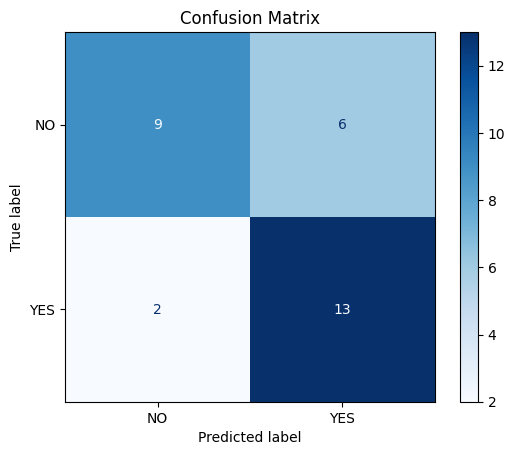

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(original_labels, predicted_labels)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()


# Few Shot Classification


In [87]:
def format_windows_for_prompt(windows):
    """
    Formats the windows into a prompt-friendly string.
    Args:
        windows (list): A list of 3D arrays, where each array represents one window.
    Returns:
        str: A formatted string for the prompt.
    """
    formatted_data = "\n\n".join(
        [f"Window {i + 1}:\n{np.array(window)}" for i, window in enumerate(windows)]
    )
    return formatted_data

# Format training windows for few-shot examples
few_shot_examples = format_windows_for_prompt(train_windows)

# Format testing windows
formatted_test_windows = format_windows_for_prompt(test_windows)

# Create the prompt with few-shot examples
prompt = f"""
Analyze the following accelerometer data, where each dataset represents 50 timesteps of 3-axis measurements (X, Y, Z).
Each row corresponds to one timestep. For each dataset, determine whether it indicates a "fall" or "no fall".
Provide the answer for each dataset as "Window X: YES" or "Window X: NO".

Here are some labeled examples:

{few_shot_examples}

Now, analyze the following data:

{formatted_test_windows}

Label each window separately.
"""

#print(prompt)

# Generation Config
config = genai.GenerationConfig(
    temperature=0.0, top_p=1.0
)

# Pass the prompt to the model
response = model.generate_content(prompt, generation_config=config)

# Print the response
print(response.text)


Based on the provided examples and a heuristic approach focusing on significant acceleration changes and near-zero readings in one or more axes, here's a possible labeling of the new data:

* **Window 1: NO**  The data shows some variation, but no sudden large changes or near-zero patterns indicative of a fall.

* **Window 2: NO** Similar to Window 1, there's no clear indication of a fall.

* **Window 3: NO**  The data is relatively stable, suggesting no fall.

* **Window 4: NO** While there's a larger spike in the Z-axis around timestep 32, the overall pattern doesn't strongly resemble a fall.

* **Window 5: NO** The data is fairly consistent, with no abrupt changes.

* **Window 6: NO**  There's a spike at the beginning, but the rest of the data doesn't suggest a fall.

* **Window 7: NO**  The data shows some fluctuations, but no clear fall pattern.

* **Window 8: NO**  Despite some larger variations, the data doesn't fit the fall profile from the examples.

* **Window 9: NO** The dat

In [88]:

# Extract reponse text
response_text = response.text

# Extract predictions
predicted_labels = extract_predictions(response_text)

# Print the extracted predictions
print(predicted_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [89]:
# Original labels from sampled_labels (replace this with your actual variable)
original_labels = test_labels.flatten()

# Compute the classification report and confusion matrix
print("Classification Report:")
print(classification_report(original_labels, predicted_labels, target_names=["NO", "YES"]))

print("\nConfusion Matrix:")
print(confusion_matrix(original_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

          NO       0.79      1.00      0.88        15
         YES       1.00      0.73      0.85        15

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.86        30
weighted avg       0.89      0.87      0.86        30


Confusion Matrix:
[[15  0]
 [ 4 11]]


<Figure size 800x600 with 0 Axes>

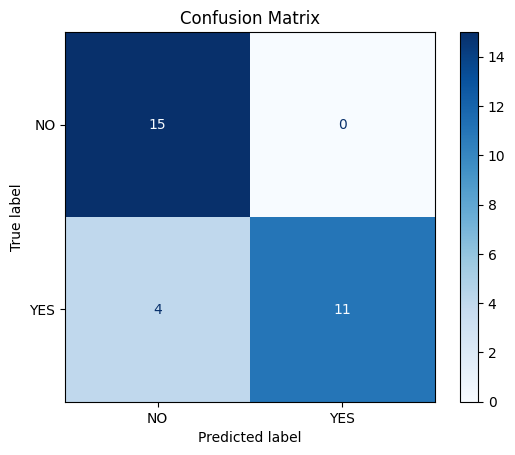

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(original_labels, predicted_labels)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()
